In [1]:
%matplotlib inline
%precision 3

from numpy.random import randn
import numpy as np
import pandas as pd
np.random.seed(123)
import os
import re
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 10

import datetime

from numpy import nan as NA

In [2]:
#!powershell -command "& {gc NCDB_1999_to_2014.csv -head 10}"
!powershell -command "& {gc NCDB_1999_to_2014_s.csv -head 10}"

C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
2013,06,2,12,2,02,21,02,1,1,1,01,02,01,2005,01,M,28,11,2,02,1
2013,06,2,09,2,01,06,02,1,1,1,18,01,11,2008,01,F,42,11,1,02,1
2013,06,2,09,2,01,06,02,1,1,1,18,01,11,2008,02,M,04,12,2,01,2
2013,06,2,09,2,01,06,02,1,1,1,18,01,11,2008,03,F,33,98,2,UU,U
2013,06,2,08,2,02,36,02,1,1,3,01,01,01,2005,01,F,44,11,2,02,1
2013,06,2,08,2,02,36,02,1,1,3,01,02,01,2002,01,M,51,11,1,02,1
2013,06,2,11,2,01,06,02,1,1,2,03,01,01,1997,01,M,45,11,1,02,1
2013,06,2,11,2,01,06,02,1,1,2,03,99,NN,NNNN,01,M,19,99,2,13,3
2013,06,2,11,2,01,06,02,1,1,1,01,01,01,2012,01,F,33,11,1,02,1


In [3]:
#accident = pd.read_csv('NCDB_1999_to_2014.csv', engine = 'python')
accident = pd.read_csv('NCDB_1999_to_2014_s.csv', engine = 'python')

In [4]:
#replace all column head to lower case.

accident.columns = accident.columns.map(lambda x: x[:].lower())
accident

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,2013,06,2,12,2,02,21,02,1,1,...,02,01,2005,01,M,28,11,2,02,1
1,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,01,F,42,11,1,02,1
2,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,02,M,04,12,2,01,2
3,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,03,F,33,98,2,UU,U
4,2013,06,2,08,2,02,36,02,1,1,...,01,01,2005,01,F,44,11,2,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491543,2014,UU,U,UU,2,UU,UU,01,U,U,...,13,07,UUUU,01,M,24,11,1,NN,1
491544,2014,UU,U,23,2,01,06,05,1,1,...,01,14,2006,01,M,29,96,2,09,5
491545,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
491546,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U


In [5]:
#check the non-numberic values in date-time columns

accident[accident['c_mnth'].str.contains('[^0-9]')|
         accident['c_wday'].str.contains('[^0-9]')|
         accident['c_hour'].str.contains('[^0-9]')]

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
764,2013,06,2,UU,2,02,21,02,1,1,...,01,01,2009,01,F,53,11,2,02,1
765,2013,06,2,UU,2,02,21,02,1,1,...,02,01,2002,01,F,25,11,1,02,1
839,2013,06,2,UU,1,01,04,UU,1,1,...,01,01,2006,01,M,34,11,3,01,1
1242,2013,06,2,UU,2,03,21,02,1,1,...,01,08,2007,01,M,53,11,1,02,1
1243,2013,06,2,UU,2,03,21,02,1,1,...,02,01,1998,01,M,71,11,2,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491543,2014,UU,U,UU,2,UU,UU,01,U,U,...,13,07,UUUU,01,M,24,11,1,NN,1
491544,2014,UU,U,23,2,01,06,05,1,1,...,01,14,2006,01,M,29,96,2,09,5
491545,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
491546,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U


In [6]:
#remove all special values (unknown to us) in date-time columns, prepare for using date series as index.
#make a copy "df" for further analysis, avoid mess up the original data "accident".

df = accident[:]
df[['c_mnth','c_wday','c_hour']]=df[['c_mnth','c_wday','c_hour']].replace('[^0-9]+',np.nan,regex=True)

#df.isnull().sum().sort_values()
df.dropna(axis=0,subset=['c_mnth','c_wday','c_hour'],inplace=True)
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,2013,06,2,12,2,02,21,02,1,1,...,02,01,2005,01,M,28,11,2,02,1
1,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,01,F,42,11,1,02,1
2,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,02,M,04,12,2,01,2
3,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,03,F,33,98,2,UU,U
4,2013,06,2,08,2,02,36,02,1,1,...,01,01,2005,01,F,44,11,2,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491519,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,01,M,44,11,1,02,1
491520,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,02,M,34,13,2,02,2
491521,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1
491522,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,02,M,26,13,1,02,2


In [7]:
#generate the date-time column "date", which could be assigned as index later.
# Caution: the "date

df['date'] = pd.DatetimeIndex(df['c_year'].map(str) + '-' + df['c_mnth'])

#df['date'] = pd.PeriodIndex(df['c_year'].map(str) + '-' + df['c_mnth'], freq='M')

df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user,date
0,2013,06,2,12,2,02,21,02,1,1,...,01,2005,01,M,28,11,2,02,1,2013-06-01
1,2013,06,2,09,2,01,06,02,1,1,...,11,2008,01,F,42,11,1,02,1,2013-06-01
2,2013,06,2,09,2,01,06,02,1,1,...,11,2008,02,M,04,12,2,01,2,2013-06-01
3,2013,06,2,09,2,01,06,02,1,1,...,11,2008,03,F,33,98,2,UU,U,2013-06-01
4,2013,06,2,08,2,02,36,02,1,1,...,01,2005,01,F,44,11,2,02,1,2013-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491519,2014,12,7,14,2,02,41,01,1,5,...,05,2008,01,M,44,11,1,02,1,2014-12-01
491520,2014,12,7,14,2,02,41,01,1,5,...,05,2008,02,M,34,13,2,02,2,2014-12-01
491521,2014,12,7,19,2,01,03,01,1,3,...,01,2001,01,F,35,11,2,02,1,2014-12-01
491522,2014,12,7,19,2,01,03,01,1,3,...,01,2001,02,M,26,13,1,02,2,2014-12-01


In [8]:
# this line use 'date' as index, meke 'df' becoming time series.

#df = df.set_index('date')
#df

In [9]:
# this code to check how many missing values.

# df.isnull().sum().sort_values()


In [10]:
# this code to check detail of missing values.

# df[df['c_vehs'].isnull()]


#### Proposed analytics for each selected category:
1. Category statistics (max, min, mean, etc.)
2. Trend over the whole period (increase, decrease, fluky)
3. Correlation between selected category and one or multiple other categories (as per table below)
The result of analysis for all selected categories will contribute to our recommendations in the conclusion. 
P.S.: We don't need to analyse all categories.

|Correlation combination|Collision date (day of week, hour)|Collision severity|Number of vehicles involved in collision|Collision configuration|Weather condition|Vehicle type|
|:--|:--|:--|:--|:--|:--|:--|
|Road alignment|R|R|R|R|-|-|
|Vehicle type|R|R|R|R|R|-|
|Vehicle model year|R|R|R|R|R|R|


### 1 Road Alignment
### 1.1) Road Alignment & Time relation

In [11]:
# slice the columns I would analyse from original dataset.

dfa = df.loc[:,['date','c_year','c_mnth','c_wday','c_hour','c_sev','c_vehs','c_conf','c_wthr','c_raln','v_type','v_year']]
dfa

,date,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_wthr,c_raln,v_type,v_year
0,2013-06-01,2013,06,2,12,2,02,21,1,1,01,2005
1,2013-06-01,2013,06,2,09,2,01,06,1,1,11,2008
2,2013-06-01,2013,06,2,09,2,01,06,1,1,11,2008
3,2013-06-01,2013,06,2,09,2,01,06,1,1,11,2008
4,2013-06-01,2013,06,2,08,2,02,36,1,3,01,2005
...,...,...,...,...,...,...,...,...,...,...,...,...
491519,2014-12-01,2014,12,7,14,2,02,41,1,1,05,2008
491520,2014-12-01,2014,12,7,14,2,02,41,1,1,05,2008
491521,2014-12-01,2014,12,7,19,2,01,03,1,4,01,2001
491522,2014-12-01,2014,12,7,19,2,01,03,1,4,01,2001


In [12]:
#check how many unknown in road alignment.

dfa['c_raln'].value_counts().sort_index()

1    360937
2     42704
3     28025
4     15922
5      5898
6      4541
Q       932
U     29119
Name: c_raln, dtype: int64

In [13]:
# Make a slice only focusing on c_raln: road alignment.

df1 = dfa.loc[:,['date','c_raln']]

#Agregate the events by month into a summarized dataframe.
df2 = df1.groupby(['date','c_raln']).size().unstack()
df2

c_raln,1,2,3,4,5,6,Q,U
date,,,,,,,,
2013-06-01,15668,1867,1198,644,235,165,43,1495
2013-07-01,21836,2601,1502,825,348,260,58,1739
2013-08-01,21878,2607,1661,953,316,240,51,1786
2013-09-01,21262,2438,1431,822,337,252,60,1733
2013-10-01,21573,2595,1325,806,332,237,61,1764
...,...,...,...,...,...,...,...,...
2014-08-01,20084,2230,1676,904,340,225,41,1462
2014-09-01,19632,2206,1501,744,306,222,51,1564
2014-10-01,20778,2366,1319,780,214,206,65,1569


In [14]:
# df1.groupby(['date','c_raln']).size().sort_values()
# df1.groupby(['date','c_raln']).size().unstack()

#df2 = df1.groupby(['date','c_raln']).size().unstack()

#df2

# df2.iloc[:,0].sum()
#df2.resample('M').sum().iloc[:,0].sum()
#df2 = df2.resample('M').sum()


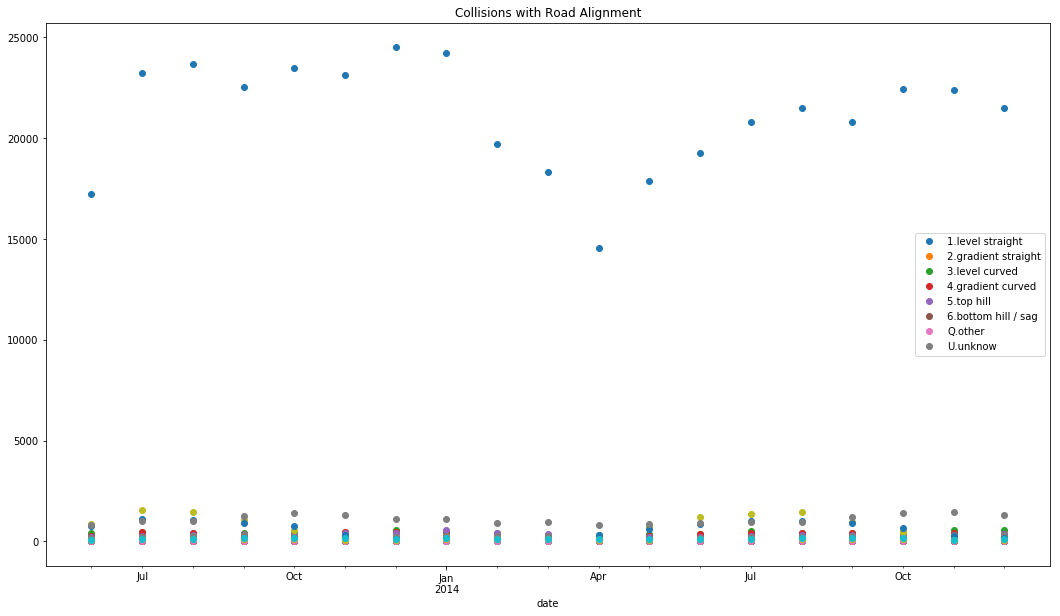

In [274]:
# Plot the dataframe into graph to visulize the result.

c_raln=['1.level straight','2.gradient straight',
           '3.level curved','4.gradient curved',
           '5.top hill','6.bottom hill / sag',
           'Q.other','U.unknow']

df2.plot(style = 'o', figsize = (18,10), title = 'Collisions with Road Alignment')
plt.legend(c_raln);


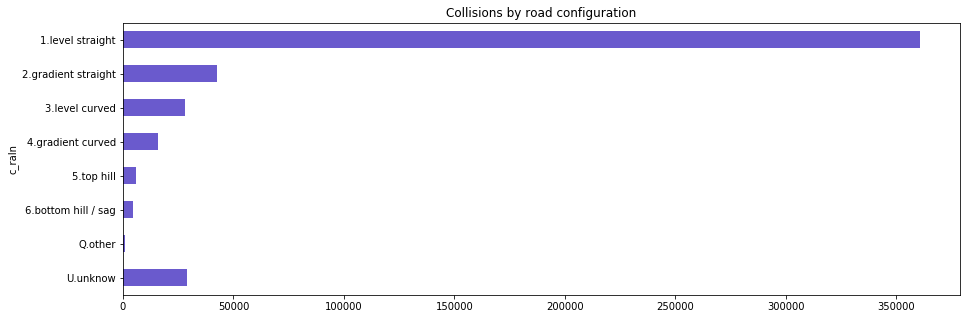

In [16]:
df3=df1.groupby('c_raln').size().sort_index(ascending=False)

df3.plot.barh(color='slateblue',figsize=(15,5),title='Collisions by road configuration')
plt.yticks(np.arange(0,8),c_raln[::-1]);


#### Conlusion:
Most collisions happened on level and straight road, reason could be the vehicle of high speed, and driver not paying enough attention given the good road condition.  Also noted that April has least accidents, see the auto-correlation analysis for seasonal patterns.

### 1.2) Road Alignment & Collision severity


In [17]:
#Use a new dataframe to analyze the relationship between Severity and Road Alignment.
#For C_Sev, 1 is fatal, and 2 is non-fatal.

df1 = dfa.loc[:,['c_raln','c_sev']]
df4 = df1.groupby(['c_raln','c_sev']).size().unstack()

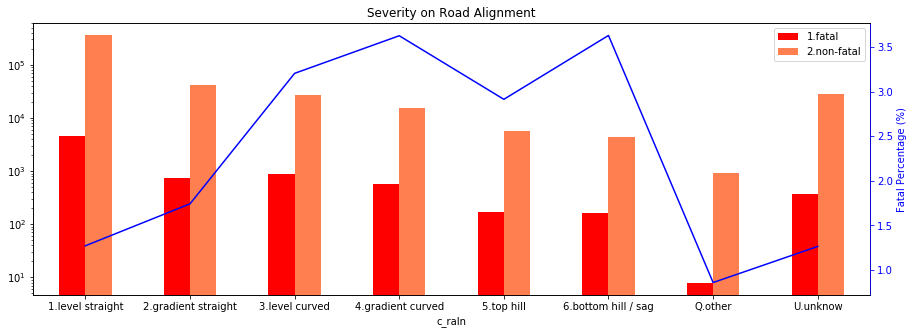

In [246]:
#Plot the relationship between Severity and Road Alignment.

#Create a twin y-axis plot area, and define axis parameters.
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.
df4.plot(kind='bar',rot=0,logy=True,color=['red','coral'],figsize=(15,5),title='Severity on Road Alignment', ax=ax1)

#Calculate the percentage of fatal injury in all accidents by different road alignment, and plot to right axis.
se1 = df4[1]/(df4[1]+df4[2])*100
se1.plot(color='b', ax=ax2)

plt.xticks(np.arange(0,8),c_raln)
ax1.legend(['1.fatal','2.non-fatal']);


#### Conclusion:
Fatal injury represent a very small portion of all accident (less than 4% in any given cases).  It's also obvious that the level-straight road has less fatal injury, though the total number is much more than other cases; instead, the uneven condition (curved and noncurved) may produce severe accident.  This could be caused by limited sight.

### 1.3) Road Alignment & Number of vehicles involved in collision


In [19]:
df1 = dfa.loc[:,['c_raln','c_vehs']]
df1.c_vehs.replace('UU',np.nan, inplace=True)
df1.dropna(inplace=True)
df1.c_vehs=df1.c_vehs.astype(int)
df1.c_vehs.value_counts().sort_index()

#Calculate accident portion of each event, considering 58 records that have 57 vehicle involved, that should be just one accident,
# every relevant record should be only about 1/57.
df1['acc']= 1/df1.c_vehs

#Categorize number of involved vehicles into bins.
bins = [0,5,10,20,40,60]
df1['cats'] = pd.cut(df1.c_vehs,bins)

#Summarize the collisions on road alignment and number of involved vehicles.
df5 = df1.groupby(['cats','c_raln'])['acc'].sum().unstack()
df5.dropna(how='all', inplace=True)
df5.fillna(0, inplace=True)
df5

c_raln,1,2,3,4,5,6,Q,U
cats,,,,,,,,
"(0, 5]",200280.016667,23754.316667,19718.716667,11293.383333,3582.500000,2866.3,616.250000,16391.350000
"(5, 10]",261.703968,54.810714,12.793651,11.959524,2.500000,1.0,2.416667,5.666667
"(10, 20]",34.003238,3.458556,2.511765,5.333333,1.533333,0.0,0.000000,1.083333
"(20, 40]",9.044228,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
"(40, 60]",1.023256,1.017544,1.568627,0.000000,0.000000,0.0,0.000000,0.000000


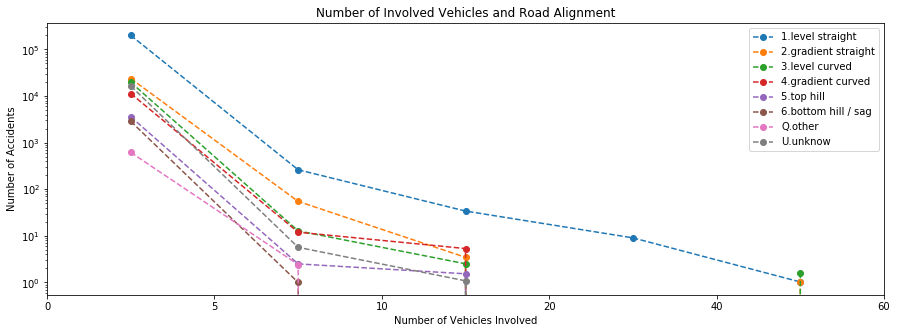

In [20]:
#Plot the result.

df5.plot(logy=True,figsize=(15,5),style='o--',title='Number of Involved Vehicles and Road Alignment')
plt.xticks(np.arange(-0.5,5.5),bins)
plt.xlabel('Number of Vehicles Involved')
plt.ylabel('Number of Accidents')
plt.legend(c_raln);

#### Conclution:
Majority accident are involving less than 5 cars.  As the plots are very similar for different road alignments, no specific relationship observed between the two varibles.

### 1.4) Road Alignment & Collision Configuration

In [33]:
#Prepare the dataset for analyse, replace non-numeric value into number to use in scatter plot.
df1 = dfa.loc[:,['c_raln','c_conf']]
df1.c_raln = df1.c_raln.replace({'Q':7,'U':8}).astype(int)
df1.c_conf = df1.c_conf.replace({'QQ':42,'UU':43,'XX':43}).astype(int)

In [115]:
#Two many collision configuration involved, iterate a list of dateframes to separate different collision config.
df6 = []
df6.append( df1[df1.c_conf < 10] )
df6.append( df1[(df1.c_conf > 20)&(df1.c_conf < 30)] )
df6.append( df1[(df1.c_conf > 30)&(df1.c_conf < 40)] )
df6.append( df1[df1.c_conf > 40] )


,c_raln,c_conf
83,1,41
84,1,41
85,1,41
86,1,41
87,1,41
...,...,...
491496,1,42
491497,1,42
491518,1,41
491519,1,41


In [203]:
#Reformat the dataframe, to summarize the collision numbers in different situation, and store in another list of
# dataframe 'df7'

se6 = []; df7 = []
for i in range(0,4):
    se6.append( df6[i].groupby(['c_raln','c_conf']).size() )
    se6[i].name = 'collision'
    df7.append( pd.DataFrame(se6[i]).reset_index() )

df7[3]

,c_raln,c_conf,collision
0,1,41,5142
1,1,42,19949
2,1,43,9439
3,2,41,369
4,2,42,2634
...,...,...,...
19,7,42,171
20,7,43,60
21,8,41,272
22,8,42,605


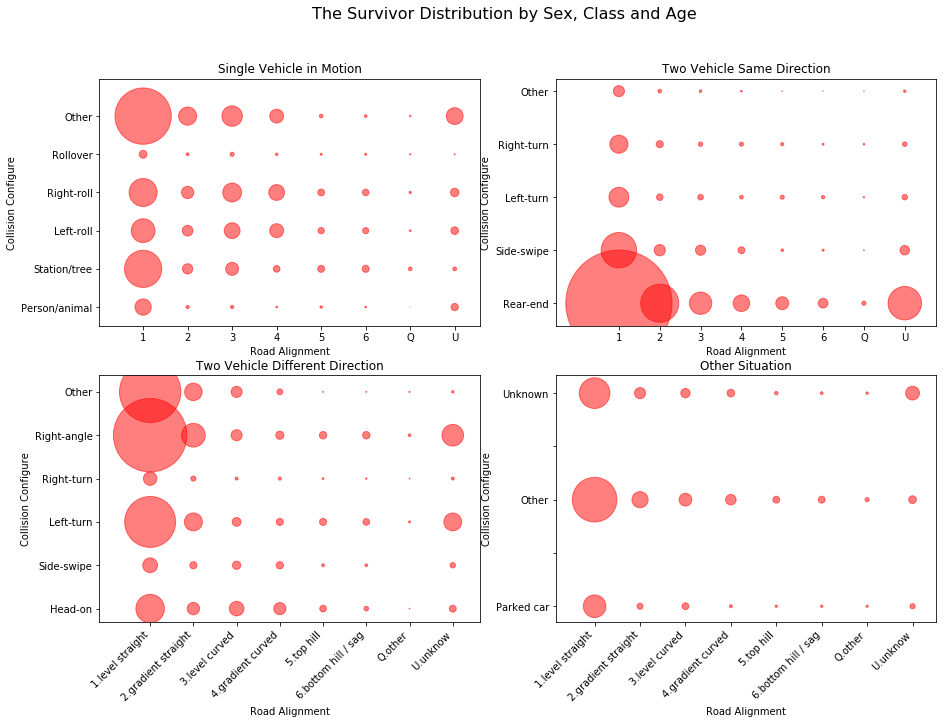

In [202]:
#Draw four subplots to show the relation between the road alignment and different collision situations.

fig = plt.figure(figsize=(15, 10))
fig.suptitle("The Relation between Road-alignment and Collision-configuration", fontsize = 16)

#Only one car in volved in collision.
ax1 = fig.add_subplot(2,2,1)
ax1.set_xticks(range(1,9))
ax1.set_xticklabels([1,2,3,4,5,6,'Q','U'])
ax1.set_xlabel("Road Alignment")

ax1.set_yticks(range(1,7))
ax1.set_yticklabels(['Person/animal','Station/tree','Left-roll','Right-roll','Rollover','Other'])
ax1.set_ylabel("Collision Configure")

ax1.set_title("Single Vehicle in Motion")
ax1.scatter(df7[0].c_raln,df7[0].c_conf,
            df7[0].collision*.1,
            alpha=0.5,color='r')


#Two car same direction.
ax2 = fig.add_subplot(2,2,2)
ax2.set_xticks(range(1,9))
ax2.set_xticklabels([1,2,3,4,5,6,'Q','U'])
ax2.set_xlabel("Road Alignment")

#ax2.set_yticks(range(21,26))
ax2.set_yticklabels(['','Rear-end','Side-swipe','Left-turn','Right-turn','Other'])
ax2.set_ylabel("Collision Configure")

ax2.set_title("Two Vehicle Same Direction")
ax2.scatter(df7[1].c_raln,df7[1].c_conf,
            df7[1].collision*.1,
            alpha=0.5,color='r')


#Two car against direction.
ax3 = fig.add_subplot(2,2,3)
ax3.set_xticks(range(1,9))
ax3.set_xticklabels(c_raln,rotation=45,ha='right')
ax3.set_xlabel("Road Alignment")

ax3.set_yticklabels(['','Head-on','Side-swipe','Left-turn','Right-turn','Right-angle','Other'])
ax3.set_ylabel("Collision Configure")

ax3.set_title("Two Vehicle Different Direction")
ax3.scatter(df7[2].c_raln,df7[2].c_conf,
            df7[2].collision*.1,
            alpha=0.5,color='r')

#Other situation.
ax4 = fig.add_subplot(2,2,4)
ax4.set_xticks(range(1,9))
ax4.set_xticklabels(c_raln,rotation=45,ha='right')
ax4.set_xlabel("Road Alignment")

ax4.set_yticklabels(['','Parked car','','Other','','Unknown'])
ax4.set_ylabel("Collision Configure")

ax4.set_title("Other Situation")
ax4.scatter(df7[3].c_raln,df7[3].c_conf,
            df7[3].collision*.1,
            alpha=0.5,color='r');


#### Conclusion:
The size of each dot indicate the collision numbers in each setting, same scale const used for all subplots, which makes the number in each plot comparable to its neibough.  in all cases, clear trend shows that the collision chance increases when road-alignment getting better, due to higher speed and less caution.  Except the unknown or "other" conditions, we can see in each cases:
1. most collion for one car accident is hitting a static object, followed closely by right and left roll on to shoulder.  Less chances for hitting a person or animal maybe because the object would move to avoid injury.
2. for two car in same direction, most accidents are rear-end collision, which clearly increase along road-alignment.
3. for two car in different direction, right-angle collision is huge, guess is in intersection.  Left turn also post a lot risk, but right-turn is very low, even lower than head-on collision.  This may be a result of the inherent complexity of left turn.

### Conclusion from Road-Alighment analysis:
From all test performed above, we have following observations:
1. Most collisions happened in level and aligned road.  Drivers should pay more attention when drive on good road condition, and follow speed limit.
2. However, bad road alignment may post higher risk of fatal accident.  Drivers need to anticipate possible outcome when the view is not so wide, and always be cautious to avoid serious injury as possible.
3. Rear-end collision is the most poppular colission type.  Keep enough space to the car in front of you, especially on well aligned road.
4. Right-angle collision and left-turn collision are also popular, wait one more second before turning your wheel, or rushing into the intersecton.


### 2 Vehicle Type
1.1) Vehicle & Time relation


In [204]:
dfa

,date,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_wthr,c_raln,v_type,v_year
0,2013-06-01,2013,06,2,12,2,02,21,1,1,01,2005
1,2013-06-01,2013,06,2,09,2,01,06,1,1,11,2008
2,2013-06-01,2013,06,2,09,2,01,06,1,1,11,2008
3,2013-06-01,2013,06,2,09,2,01,06,1,1,11,2008
4,2013-06-01,2013,06,2,08,2,02,36,1,3,01,2005
...,...,...,...,...,...,...,...,...,...,...,...,...
491519,2014-12-01,2014,12,7,14,2,02,41,1,1,05,2008
491520,2014-12-01,2014,12,7,14,2,02,41,1,1,05,2008
491521,2014-12-01,2014,12,7,19,2,01,03,1,4,01,2001
491522,2014-12-01,2014,12,7,19,2,01,03,1,4,01,2001


In [234]:

df1 = dfa.loc[:,['date','v_type']]

#Agregate the events by month into a summarized dataframe.
df2 = df1.groupby(['date','v_type']).size().unstack()
df2.fillna(0, inplace=True)
df2

v_type,01,05,06,07,08,09,10,11,14,16,17,18,19,20,21,22,23,NN,QQ,UU
date,,,,,,,,,,,,,,,,,,,,
2013-06-01,17234.0,246.0,411.0,260.0,207.0,53.0,1.0,185.0,884.0,56.0,752.0,18.0,5.0,22.0,2.0,0.0,15.0,809.0,88.0,67.0
2013-07-01,23235.0,337.0,481.0,456.0,285.0,8.0,7.0,203.0,1546.0,103.0,1129.0,37.0,14.0,27.0,0.0,0.0,15.0,1008.0,138.0,140.0
2013-08-01,23660.0,337.0,443.0,440.0,342.0,16.0,0.0,267.0,1468.0,99.0,1057.0,38.0,17.0,24.0,0.0,0.0,16.0,1018.0,119.0,131.0
2013-09-01,22556.0,308.0,439.0,387.0,307.0,284.0,1.0,353.0,1072.0,68.0,939.0,22.0,8.0,27.0,4.0,0.0,19.0,1273.0,107.0,161.0
2013-10-01,23491.0,318.0,429.0,380.0,333.0,177.0,16.0,371.0,586.0,31.0,769.0,11.0,21.0,29.0,1.0,3.0,15.0,1423.0,127.0,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,21484.0,213.0,443.0,398.0,303.0,2.0,0.0,226.0,1460.0,104.0,1010.0,9.0,11.0,45.0,7.0,0.0,10.0,959.0,107.0,171.0
2014-09-01,20816.0,273.0,442.0,433.0,337.0,134.0,4.0,283.0,978.0,58.0,926.0,12.0,8.0,36.0,4.0,0.0,20.0,1191.0,104.0,167.0
2014-10-01,22432.0,313.0,483.0,460.0,293.0,86.0,1.0,246.0,463.0,59.0,678.0,10.0,16.0,35.0,7.0,3.0,13.0,1420.0,114.0,165.0


In [317]:
v_type=['1.Light Duty Vehicle', '5.Cargo <= 4536 KG', '6.Truck <= 4536 KG',
        '7.truck > 4536 KG', '8.Road tractor', '9.School bus',
        '10.Small school bus', '11.Urban Bus', '14.Motorcycle',
        '16.Off-road', '17.Bicycle', '18.Motorhome', '19.Farm equipment',
        '20.Constr. equipment', '21.Fire engine', '22.Snowmobile',
        '23.Street car', 'N.Not Vehicle', 'Q.Others', 'U.Unknown']

In [324]:
ls=list(range(0,8))
[ls[1],ls[3]]

[1, 3]

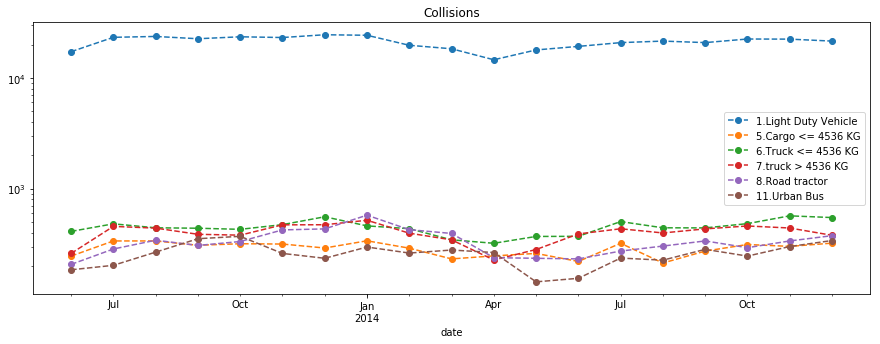

In [342]:
#df2.plot(logy=True, figsize = (18,10), style = 'o--', title = 'Collisions with Road Alignment');
df2.iloc[:,[0,1,2,3,4,7]].plot(logy=True, figsize = (15,5), style = 'o--', title = 'Collisions')

plt.legend(v_type[0:5]+[v_type[7]]);

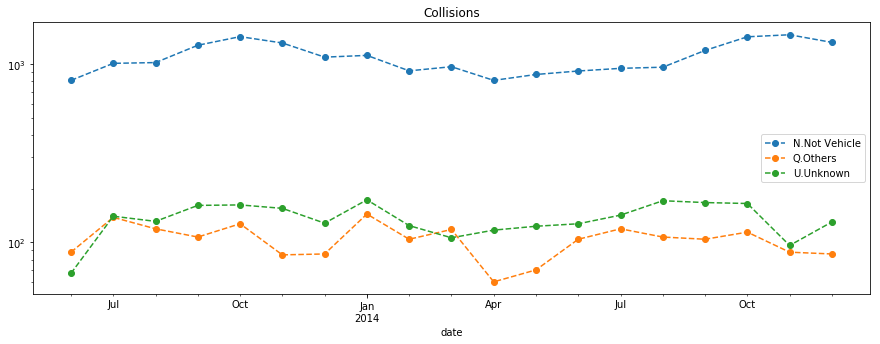

In [327]:
df2.iloc[:,17:20].plot(logy=True, figsize = (15,5), style = 'o--', title = 'Collisions')
plt.legend(v_type[17:20]);

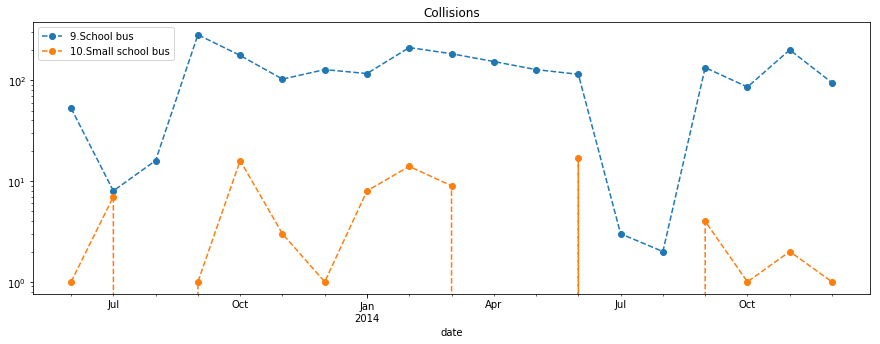

In [329]:
df2.iloc[:,5:7].plot(logy=True, figsize = (15,5), style = 'o--', title = 'Collisions')
plt.legend(v_type[5:7]);

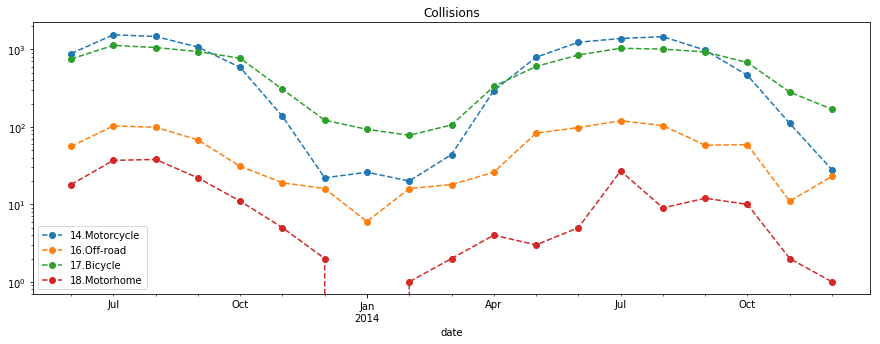

In [328]:
df2.iloc[:,8:12].plot(logy=True, figsize = (15,5), style = 'o--', title = 'Collisions')
plt.legend(v_type[8:12]);

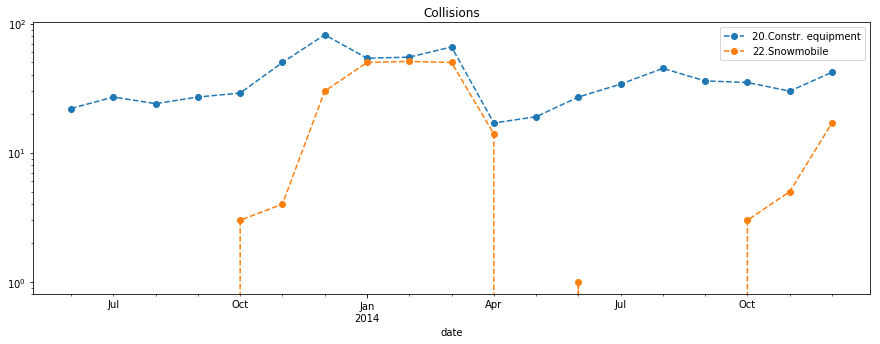

In [341]:
df2.iloc[:,[13,15]].plot(logy=True, figsize = (15,5), style = 'o--', title = 'Collisions')
plt.legend([v_type[13],v_type[15]]);

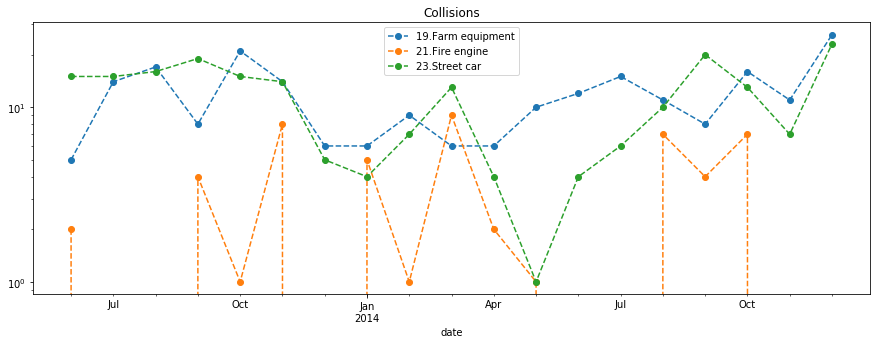

In [340]:
df2.iloc[:,[12,14,16]].plot(logy=True, figsize = (15,5), style = 'o--', title = 'Collisions')
plt.legend([v_type[12],v_type[14],v_type[16]]);